In [32]:
import matplotlib.pyplot as plt 
from CoolProp.CoolProp import PropsSI
import numpy as np
import pandas as pd


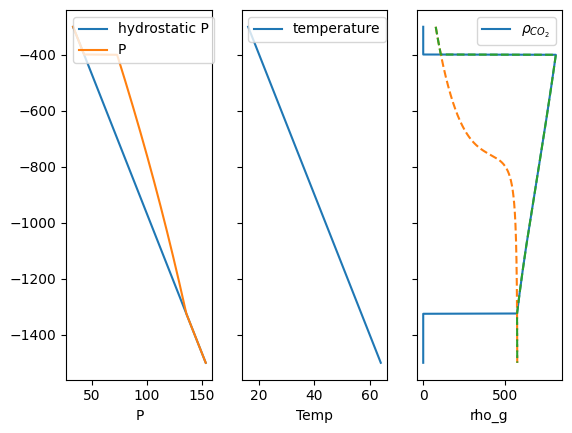

In [60]:
# reservoir aquifer pressure
aq_P = 125 # bar

# reservoir reference depth
aq_Z = -1217 # mTVDMSL

# injection pointo r base of CO2 column
base_CO2_Z = -1324 # m

# base of cement plug/barrier
barrier_Z = -400

#density brine
rho_brine = 1024 # kg/m3

#gravity acceleration
G_acc = 9.8067 # m/s2

#Create depth vector
top = 300
base = 1500

z = -np.linspace(top, base, 1+(base-top))
df = pd.DataFrame(data={'depth':z})


def P_hyd(z, ref_Z, ref_P, rho = 1024, g = 9.8067):
    """
    Creates a hydrostatic gradient based on a given density that matches a reference pressure, depth point
    """

    P_offset = ref_P*1e5 + ref_Z*rho*g
    P = (-(z*g*rho) + P_offset) / 1e5
    return P

#Hydrostatic gradient
df['P_hyd'] = P_hyd(z=z, ref_P=aq_P, ref_Z=aq_Z)

#Temperature
Tgrad = 40/1000 #thermal gradient [m/degC]
T_sf = 4 #seafloor temperature

df['Temp'] = T_sf - z*Tgrad #geothermal temperature field





# hydrostatic pressure at CO2 base
base_CO2_Phyd = P_hyd(z=base_CO2_Z, ref_P=aq_P, ref_Z=aq_Z)

# hydrostatic pressure at barrier base
barrier_Phyd = P_hyd(z=barrier_Z, ref_P=aq_P, ref_Z=aq_Z)

#vertical height between base of CO2 and base of barrier
col_CO2_height = barrier_Z - base_CO2_Z

# CO2 column
df['CO2_h'] = df['depth'] - base_CO2_Z
df.loc[(df['CO2_h']<0) | (df['CO2_h']>col_CO2_height), 'CO2_h'] = 0

# delta z
df['dz'] = df.depth.diff()

# create a column for P
df['P'] = df['P_hyd']

# create a column for Pcap
df['dPcap'] = 0
df['Pcap'] = 0
df['rho_g'] = 0




query = df.query('depth>=@base_CO2_Z & depth<=@barrier_Z')


for idx, row in query.iloc[::-1].iterrows():

    col_h  = row.CO2_h
    z = row.depth
    dz = row.dz
    T = row.Temp
    P_hyd = row.P_hyd

    if col_h == 0:
        P = P_hyd
        rho_g = PropsSI("D", "P", P*1e5, "T", T+273.15, "CO2")

        df.loc[idx, 'rho_g'] = rho_g
        Pcap = 0
    else:
        dPcap = -((rho_brine - rho_g)*dz*G_acc)/1e5


        Pcap += dPcap

        df.loc[idx, 'dPcap'] = dPcap
        df.loc[idx, 'Pcap'] = Pcap

        P = P_hyd + Pcap
        df.loc[idx, 'P'] = P
        
        rho_g = PropsSI("D", "P", P*1e5, "T", T+273.15, "CO2")
        df.loc[idx, 'rho_g'] = rho_g


fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True)

df.plot(x='P_hyd', y='depth', ax= ax1, label='hydrostatic P')
df.plot(x='P', y='depth', ax= ax1, label='P')

df.plot(x='Temp', y='depth', ax= ax2, label='temperature')
df.plot(x='rho_g', y='depth', ax= ax3, label=r'$\rho_{CO_2}$')

rho_g_0 = PropsSI("D", "P", df['P_hyd'].values*1e5, "T", df['Temp'].values+273.15, "CO2")
rho_g_f = PropsSI("D", "P", df['P'].values*1e5, "T", df['Temp'].values+273.15, "CO2")

ax3.plot(rho_g_0, df.depth, '--')
ax3.plot(rho_g_f, df.depth, '--')

In [62]:
query = df.query('depth>=@base_CO2_Z & depth<=@barrier_Z')
query

,depth,P_hyd,Temp,CO2_h,dz,P,dPcap,Pcap,rho_g
100,-400.0,42.956363,20.00,924.0,-1.0,72.918360,0.020551,29.961996,814.681450
101,-401.0,43.056784,20.04,923.0,-1.0,72.998229,0.020575,29.941445,814.439541
102,-402.0,43.157204,20.08,922.0,-1.0,73.078075,0.020598,29.920871,814.197520
103,-403.0,43.257625,20.12,921.0,-1.0,73.157897,0.020622,29.900272,813.955388
104,-404.0,43.358046,20.16,920.0,-1.0,73.237696,0.020646,29.879650,813.713143
...,...,...,...,...,...,...,...,...,...
1020,-1320.0,135.343323,56.80,4.0,-1.0,135.518767,0.043831,0.175445,577.263831
1021,-1321.0,135.443743,56.84,3.0,-1.0,135.575357,0.043851,0.131614,577.055175
1022,-1322.0,135.544164,56.88,2.0,-1.0,135.631927,0.043871,0.087763,576.846745
1023,-1323.0,135.644584,56.92,1.0,-1.0,135.688476,0.043892,0.043892,576.638541


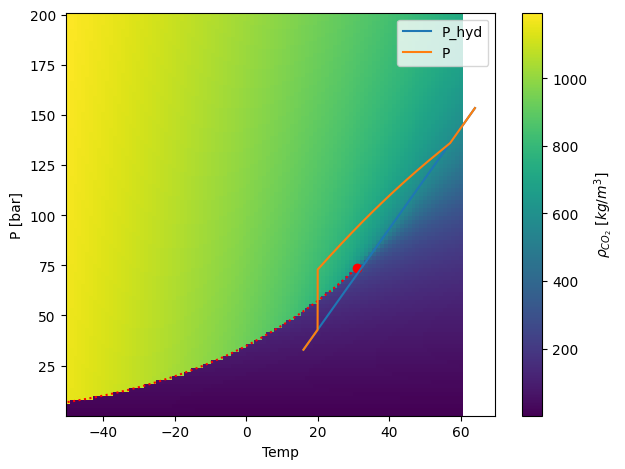

In [69]:
nx, ny = (101, 101)
T = np.linspace(-50, 60, nx)

P = np.linspace(1, 200, ny)
Tv, Pv = np.meshgrid(T, P)



Tv = Tv.flatten()
Pv = Pv.flatten()

density_coolprop = PropsSI("D", "P", Pv*1e5, "T", Tv+273.15, "CO2")



Pcrit = PropsSI('CO2', 'pcrit')
Tcrit = PropsSI('CO2', 'Tcrit')

Tphase = np.linspace(273.15-50, Tcrit, 2000)
Pphase = PropsSI('P','T',Tphase,'Q',0,'CO2')

Tv = Tv.reshape(nx, ny)
Pv = Pv.reshape(nx, ny)
density_coolprop = density_coolprop.reshape(nx, ny)

fig, ax = plt.subplots()

pcm = ax.pcolormesh(Tv, Pv, density_coolprop, shading='nearest')

ax.scatter(Tcrit-273.15, Pcrit/1e5, c='red', label='critical P,T')
ax.plot(Tphase-273.15, Pphase/1e5, c='red', ls=':')
ax.set_xlabel('T [$\degree$C]')
ax.set_ylabel('P [bar]')

df.plot(x='Temp', y='P_hyd', ax=ax)
df.plot(x='Temp', y='P', ax=ax)

fig.colorbar(pcm, label = r'$\rho_{CO_2}$ [$kg/m^3$]')

fig.tight_layout()

# fig.savefig('CO2_density.png')
